### Bitcoin LSTM Model

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os

os.chdir('C:/Users/gerar/OneDrive/Documentos/GitHub/bitcoinPred')  # Set the working directory

# Load and preprocess the data
def load_and_prepare_data(file_path, sequence_length=30):
    """
    Loads the dataset and prepares it for LSTM by creating sequences.

    Args:
        file_path (str): Path to the processed CSV file.
        sequence_length (int): Number of time steps in each sequence.

    Returns:
        X, y: Prepared sequences and corresponding targets.
    """
    # Load the dataset
    df = pd.read_csv(file_path)

    # Scale the features to the range [0, 1]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])  # Sequence of features
        y.append(scaled_data[i, 0])  # Target is the 'close' price (first column)

    X, y = np.array(X), np.array(y)
    return X, y, scaler

# Build the LSTM model
def build_lstm_model(input_shape):
    """
    Builds an LSTM model.

    Args:
        input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
        model: Compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the LSTM model
def train_lstm_model(X_train, y_train, X_val, y_val, input_shape, epochs=50, batch_size=32):
    """
    Trains the LSTM model.

    Args:
        X_train, y_train: Training data and targets.
        X_val, y_val: Validation data and targets.
        input_shape (tuple): Shape of the input data (timesteps, features).
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        model: Trained LSTM model.
    """
    model = build_lstm_model(input_shape)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )
    return model, history

# Main execution block
file_path = "data/processed/btc_lstm.csv"  # Path to the LSTM-ready dataset
sequence_length = 30  # Number of time steps in each sequence

try:
    # Load and prepare the data
    X, y, scaler = load_and_prepare_data(file_path, sequence_length)

    # Split the data into training and validation sets (80% train, 20% validation)
    split_index = int(0.8 * len(X))
    X_train, X_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]

    # Train the LSTM model
    input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
    model, history = train_lstm_model(X_train, y_train, X_val, y_val, input_shape)

    print("Model training complete!")

except FileNotFoundError:
    print(f"Error: The file {file_path} was not found. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")

c:\Users\gerar\OneDrive\Documentos\GitHub\bitcoinPred\bitcoinPredEnv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.0139 - val_loss: 0.0092
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0014 - val_loss: 0.0110
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0011 - val_loss: 0.0056
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 9.5176e-04 - val_loss: 0.0086
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 8.2013e-04 - val_loss: 0.0038
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 8.9079e-04 - val_loss: 0.0127
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 9.9464e-04 - val_loss: 0.0101
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 8.0107e-04 - val_loss: 0.0095
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 7.9557e-04 - val_loss: 0.0052
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 7.4403e-04 - val_loss: 0.0043
Model training complete!


### Model Evaluation
#### Calculate metrics like Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) on the validation set.

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Inverse transform the predictions and actual values to the original scale
y_val_pred_original = scaler.inverse_transform(np.concatenate((y_val_pred, np.zeros((y_val_pred.shape[0], X_val.shape[2] - 1))), axis=1))[:, 0]
y_val_original = scaler.inverse_transform(np.concatenate((y_val.reshape(-1, 1), np.zeros((y_val.shape[0], X_val.shape[2] - 1))), axis=1))[:, 0]

# Calculate evaluation metrics
mae = mean_absolute_error(y_val_original, y_val_pred_original)
rmse = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Mean Absolute Error (MAE): 4380.20
Root Mean Squared Error (RMSE): 6325.65


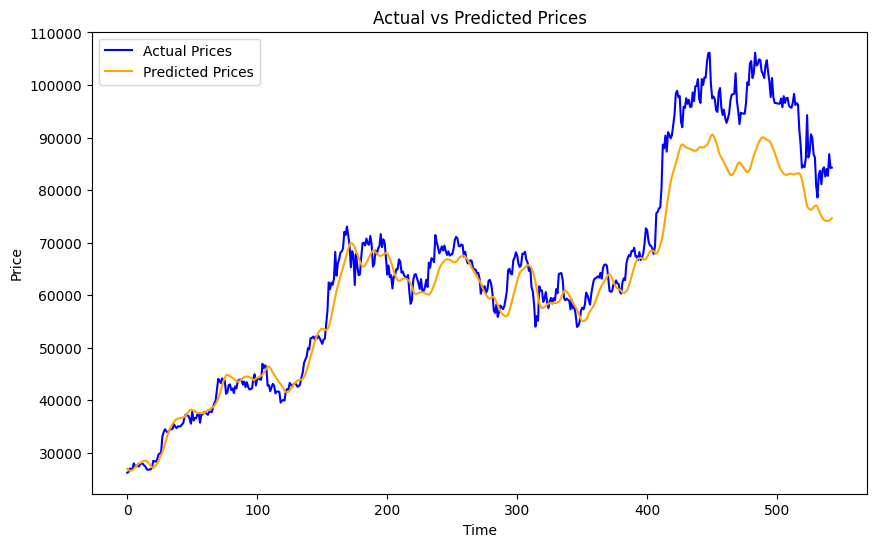

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_val_original, label="Actual Prices", color="blue")
plt.plot(y_val_pred_original, label="Predicted Prices", color="orange")
plt.title("Actual vs Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [6]:
# Split the data into training and testing sets (80% train, 20% test)
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Train the LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
model, history = train_lstm_model(X_train, y_train, X_test, y_test, input_shape)

# Evaluate the model on the test set
y_test_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to the original scale
y_test_pred_original = scaler.inverse_transform(np.concatenate((y_test_pred, np.zeros((y_test_pred.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]
y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_original, y_test_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Epoch 1/50


c:\Users\gerar\OneDrive\Documentos\GitHub\bitcoinPred\bitcoinPredEnv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.0126 - val_loss: 0.0067
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0016 - val_loss: 0.0064
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 9.8329e-04 - val_loss: 0.0058
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0010 - val_loss: 0.0097
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 9.9362e-04 - val_loss: 0.0028
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 7.3873e-04 - val_loss: 0.0025
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 8.4990e-04 - val_loss: 0.0038
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 7.0953e-04 - val_loss: 0.0018
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 7.8917e-04 - val_loss: 0.0041
Epoch 12/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/ste

In [7]:
# Use the last 7 rows for training and the next row for testing
X_train, y_train = X[-8:-1], y[-8:-1]  # Last 7 rows
X_test, y_test = X[-1:], y[-1:]        # Current day (last row)

# Train the LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
model, history = train_lstm_model(X_train, y_train, X_test, y_test, input_shape)

# Evaluate the model on the test set
y_test_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to the original scale
y_test_pred_original = scaler.inverse_transform(np.concatenate((y_test_pred, np.zeros((y_test_pred.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]
y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]

print(f"Actual Price: {y_test_original[0]:.2f}")
print(f"Predicted Price: {y_test_pred_original[0]:.2f}")

Epoch 1/50


c:\Users\gerar\OneDrive\Documentos\GitHub\bitcoinPred\bitcoinPredEnv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.8090 - val_loss: 0.5505
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.5406 - val_loss: 0.3073
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.3679 - val_loss: 0.1317
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.1320 - val_loss: 0.0275
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.0208 - val_loss: 7.9966e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.0060 - val_loss: 0.0396
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.0577 - val_loss: 0.0881
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0922 - val_loss: 0.1109
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.1797 - val_loss: 0.0914
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.1013 - val_loss: 0.0579
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
Actual Price: 84280.04
Predicted Price: 87190.78


### Updated Code for Normalization

In [8]:
# Load and preprocess the data
def load_and_prepare_data(file_path, sequence_length=30):
    """
    Loads the dataset and prepares it for LSTM by creating sequences.

    Args:
        file_path (str): Path to the processed CSV file.
        sequence_length (int): Number of time steps in each sequence.

    Returns:
        X_train, X_val, y_train, y_val, scaler: Prepared sequences and corresponding targets.
    """
    # Load the dataset
    df = pd.read_csv(file_path)

    # Split the data into training and validation sets (80% train, 20% validation)
    split_index = int(0.8 * len(df))
    train_data = df.iloc[:split_index]
    val_data = df.iloc[split_index:]

    # Scale the features using MinMaxScaler
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    val_scaled = scaler.transform(val_data)

    # Create sequences for training
    X_train, y_train = [], []
    for i in range(sequence_length, len(train_scaled)):
        X_train.append(train_scaled[i-sequence_length:i])  # Sequence of features
        y_train.append(train_scaled[i, 0])  # Target is the 'close' price (first column)

    # Create sequences for validation
    X_val, y_val = [], []
    for i in range(sequence_length, len(val_scaled)):
        X_val.append(val_scaled[i-sequence_length:i])
        y_val.append(val_scaled[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)

    return X_train, X_val, y_train, y_val, scaler


# Execution block
if __name__ == "__main__":
    # File path to the processed dataset
    file_path = "data/processed/btc_lstm.csv"

    # Sequence length for LSTM
    sequence_length = 30

    # Load and prepare the data
    try:
        X_train, X_val, y_train, y_val, scaler = load_and_prepare_data(file_path, sequence_length)

        # Print dataset shapes
        print(f"Training data shape (X_train): {X_train.shape}")
        print(f"Validation data shape (X_val): {X_val.shape}")
        print(f"Training target shape (y_train): {y_train.shape}")
        print(f"Validation target shape (y_val): {y_val.shape}")

    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found. Please check the file path.")
    except Exception as e:
        print(f"An error occurred: {e}")

Training data shape (X_train): (2162, 30, 13)
Validation data shape (X_val): (519, 30, 13)
Training target shape (y_train): (2162,)
Validation target shape (y_val): (519,)


Epoch 1/50


c:\Users\gerar\OneDrive\Documentos\GitHub\bitcoinPred\bitcoinPredEnv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0205 - val_loss: 0.0126
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0040 - val_loss: 0.0091
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0033 - val_loss: 0.0134
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0031 - val_loss: 0.0085
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0028 - val_loss: 0.0144
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0028 - val_loss: 0.0137
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0025 - val_loss: 0.0156
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0020 - val_loss: 0.0128
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0021 - val_loss: 0.0244
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Mean Absolute Error (MAE): 4421.48
Root Mean Squared Error (RMSE): 5928.64


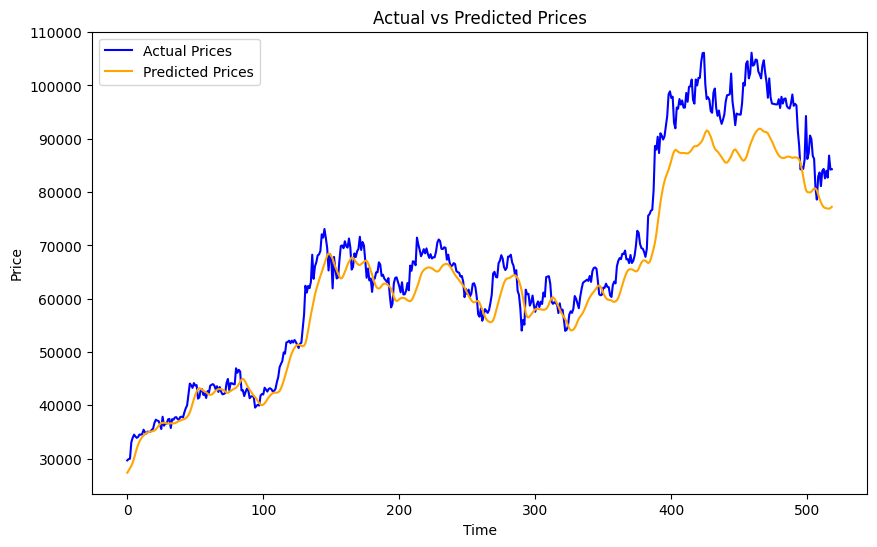

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Build the LSTM model
def build_lstm_model(input_shape):
    """
    Builds an LSTM model.

    Args:
        input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
        model: Compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the LSTM model
def train_lstm_model(X_train, y_train, X_val, y_val, input_shape, epochs=50, batch_size=32):
    """
    Trains the LSTM model.

    Args:
        X_train, y_train: Training data and targets.
        X_val, y_val: Validation data and targets.
        input_shape (tuple): Shape of the input data (timesteps, features).
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        model: Trained LSTM model.
        history: Training history object.
    """
    model = build_lstm_model(input_shape)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )
    return model, history

# Evaluate the model
def evaluate_model(model, X_val, y_val, scaler):
    """
    Evaluates the trained LSTM model on the validation set.

    Args:
        model: Trained LSTM model.
        X_val, y_val: Validation data and targets.
        scaler: Scaler used for normalization.

    Returns:
        None
    """
    # Make predictions on the validation set
    y_val_pred = model.predict(X_val)

    # Inverse transform the predictions and actual values to the original scale
    y_val_pred_original = scaler.inverse_transform(
        np.concatenate((y_val_pred, np.zeros((y_val_pred.shape[0], X_val.shape[2] - 1))), axis=1)
    )[:, 0]
    y_val_original = scaler.inverse_transform(
        np.concatenate((y_val.reshape(-1, 1), np.zeros((y_val.shape[0], X_val.shape[2] - 1))), axis=1)
    )[:, 0]

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    rmse = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

    # Plot actual vs predicted prices
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(y_val_original, label="Actual Prices", color="blue")
    plt.plot(y_val_pred_original, label="Predicted Prices", color="orange")
    plt.title("Actual vs Predicted Prices")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Main execution block
if __name__ == "__main__":
    # Ensure the data preparation code has been executed and X_train, X_val, y_train, y_val, scaler are available
    try:
        # Train the LSTM model
        input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
        model, history = train_lstm_model(X_train, y_train, X_val, y_val, input_shape)

        # Evaluate the model
        evaluate_model(model, X_val, y_val, scaler)

    except Exception as e:
        print(f"An error occurred: {e}")

### Use only the last 1,000 rows

Epoch 1/50


c:\Users\gerar\OneDrive\Documentos\GitHub\bitcoinPred\bitcoinPredEnv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0411 - val_loss: 0.0182
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0040 - val_loss: 0.0253
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0025 - val_loss: 0.0139
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0027 - val_loss: 0.0124
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0026 - val_loss: 0.0119
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0022 - val_loss: 0.0074
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0020 - val_loss: 0.0101
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0023 - val_loss: 0.0236
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0026 - val_loss: 0.0075
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0021 - val_loss: 0.0097
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0016 - val_loss: 0.0121
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
Mean Absolute Error (MAE): 6390.87
R

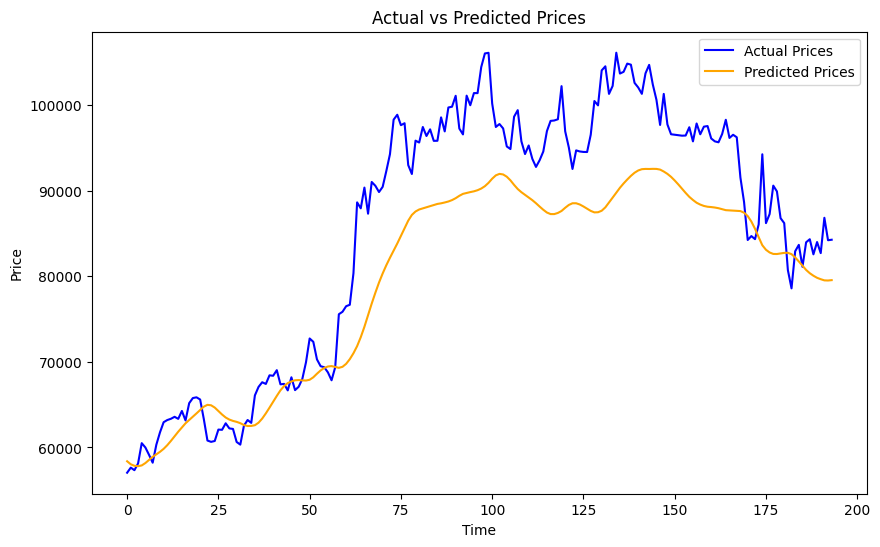

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load and preprocess the data
def load_and_prepare_data(file_path, sequence_length=30, num_rows=1000):
    """
    Loads the dataset and prepares it for LSTM by creating sequences.

    Args:
        file_path (str): Path to the processed CSV file.
        sequence_length (int): Number of time steps in each sequence.
        num_rows (int): Number of rows to use from the dataset.

    Returns:
        X_train, X_val, y_train, y_val, scaler: Prepared sequences and corresponding targets.
    """
    # Load the dataset and use only the last `num_rows` rows
    df = pd.read_csv(file_path).tail(num_rows)

    # Scale the features using MinMaxScaler
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])  # Sequence of features
        y.append(scaled_data[i, 0])  # Target is the 'close' price (first column)

    X, y = np.array(X), np.array(y)

    # Split into training and validation sets (80% train, 20% validation)
    split_index = int(0.8 * len(X))
    X_train, X_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]

    return X_train, X_val, y_train, y_val, scaler

# Build the LSTM model
def build_lstm_model(input_shape):
    """
    Builds an LSTM model.

    Args:
        input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
        model: Compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the LSTM model
def train_lstm_model(X_train, y_train, X_val, y_val, input_shape, epochs=50, batch_size=32):
    """
    Trains the LSTM model.

    Args:
        X_train, y_train: Training data and targets.
        X_val, y_val: Validation data and targets.
        input_shape (tuple): Shape of the input data (timesteps, features).
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        model: Trained LSTM model.
        history: Training history object.
    """
    model = build_lstm_model(input_shape)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )
    return model, history

# Evaluate the model
def evaluate_model(model, X_val, y_val, scaler):
    """
    Evaluates the trained LSTM model on the validation set.

    Args:
        model: Trained LSTM model.
        X_val, y_val: Validation data and targets.
        scaler: Scaler used for normalization.

    Returns:
        None
    """
    # Make predictions on the validation set
    y_val_pred = model.predict(X_val)

    # Inverse transform the predictions and actual values to the original scale
    y_val_pred_original = scaler.inverse_transform(
        np.concatenate((y_val_pred, np.zeros((y_val_pred.shape[0], X_val.shape[2] - 1))), axis=1)
    )[:, 0]
    y_val_original = scaler.inverse_transform(
        np.concatenate((y_val.reshape(-1, 1), np.zeros((y_val.shape[0], X_val.shape[2] - 1))), axis=1)
    )[:, 0]

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    rmse = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

    # Plot actual vs predicted prices
    plt.figure(figsize=(10, 6))
    plt.plot(y_val_original, label="Actual Prices", color="blue")
    plt.plot(y_val_pred_original, label="Predicted Prices", color="orange")
    plt.title("Actual vs Predicted Prices")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Main execution block
if __name__ == "__main__":
    # File path to the processed dataset
    file_path = "data/processed/btc_lstm.csv"

    # Sequence length for LSTM
    sequence_length = 30

    # Load and prepare the data using only the last 1,000 rows
    try:
        X_train, X_val, y_train, y_val, scaler = load_and_prepare_data(file_path, sequence_length, num_rows=1000)

        # Train the LSTM model
        input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
        model, history = train_lstm_model(X_train, y_train, X_val, y_val, input_shape)

        # Evaluate the model
        evaluate_model(model, X_val, y_val, scaler)

    except Exception as e:
        print(f"An error occurred: {e}")

Epoch 1/50


c:\Users\gerar\OneDrive\Documentos\GitHub\bitcoinPred\bitcoinPredEnv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0223 - val_loss: 0.0044
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0017 - val_loss: 0.0040
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0013 - val_loss: 0.0057
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0013 - val_loss: 0.0074
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0011 - val_loss: 0.0061
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 9.5417e-04 - val_loss: 0.0057
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 9.5227e-04 - val_loss: 0.0057
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 8.7412e-04 - val_loss: 0.0061
Epoch 12/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 7.

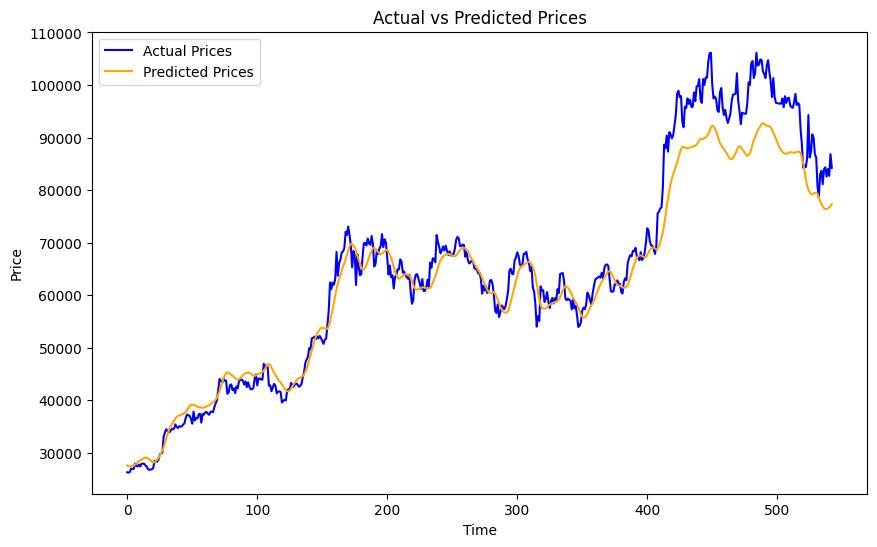

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load and preprocess the data
def load_and_prepare_data(file_path, sequence_length=30):
    """
    Loads the dataset and prepares it for LSTM by creating sequences.

    Args:
        file_path (str): Path to the processed CSV file.
        sequence_length (int): Number of time steps in each sequence.

    Returns:
        X_train, X_val, y_train, y_val, scaler: Prepared sequences and corresponding targets.
    """
    # Load the dataset
    df = pd.read_csv(file_path)

    # Select the relevant columns (all variables except the date column)
    df = df.iloc[:, 1:]  # Exclude the first column (date)

    # Scale the features using MinMaxScaler
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])  # Sequence of features
        y.append(scaled_data[i, 0])  # Target is the 'close' price (first column)

    X, y = np.array(X), np.array(y)

    # Split into training and validation sets (80% train, 20% validation)
    split_index = int(0.8 * len(X))
    X_train, X_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]

    return X_train, X_val, y_train, y_val, scaler

# Build the LSTM model
def build_lstm_model(input_shape):
    """
    Builds an LSTM model.

    Args:
        input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
        model: Compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the LSTM model
def train_lstm_model(X_train, y_train, X_val, y_val, input_shape, epochs=50, batch_size=32):
    """
    Trains the LSTM model.

    Args:
        X_train, y_train: Training data and targets.
        X_val, y_val: Validation data and targets.
        input_shape (tuple): Shape of the input data (timesteps, features).
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        model: Trained LSTM model.
        history: Training history object.
    """
    model = build_lstm_model(input_shape)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )
    return model, history

# Evaluate the model
def evaluate_model(model, X_val, y_val, scaler):
    """
    Evaluates the trained LSTM model on the validation set.

    Args:
        model: Trained LSTM model.
        X_val, y_val: Validation data and targets.
        scaler: Scaler used for normalization.

    Returns:
        None
    """
    # Make predictions on the validation set
    y_val_pred = model.predict(X_val)

    # Inverse transform the predictions and actual values to the original scale
    y_val_pred_original = scaler.inverse_transform(
        np.concatenate((y_val_pred, np.zeros((y_val_pred.shape[0], X_val.shape[2] - 1))), axis=1)
    )[:, 0]
    y_val_original = scaler.inverse_transform(
        np.concatenate((y_val.reshape(-1, 1), np.zeros((y_val.shape[0], X_val.shape[2] - 1))), axis=1)
    )[:, 0]

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    rmse = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

    # Plot actual vs predicted prices
    plt.figure(figsize=(10, 6))
    plt.plot(y_val_original, label="Actual Prices", color="blue")
    plt.plot(y_val_pred_original, label="Predicted Prices", color="orange")
    plt.title("Actual vs Predicted Prices")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Main execution block
if __name__ == "__main__":
    # File path to the processed dataset
    file_path = "data/processed/btc_linear.csv"

    # Sequence length for LSTM
    sequence_length = 30

    # Load and prepare the data
    try:
        X_train, X_val, y_train, y_val, scaler = load_and_prepare_data(file_path, sequence_length)

        # Train the LSTM model
        input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
        model, history = train_lstm_model(X_train, y_train, X_val, y_val, input_shape)

        # Evaluate the model
        evaluate_model(model, X_val, y_val, scaler)

    except Exception as e:
        print(f"An error occurred: {e}")

Epoch 1/50


c:\Users\gerar\OneDrive\Documentos\GitHub\bitcoinPred\bitcoinPredEnv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0309 - val_loss: 0.0054
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0019 - val_loss: 0.0055
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0015 - val_loss: 0.0064
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0012 - val_loss: 0.0037
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0014 - val_loss: 0.0075
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 9.9816e-04 - val_loss: 0.0045
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 9.1679e-04 - val_loss: 0.0019
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 12/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0011

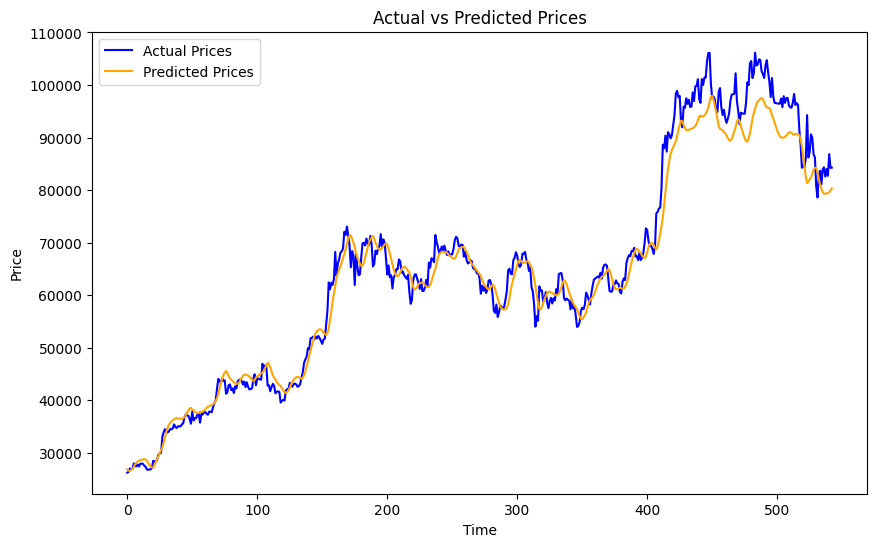

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load and preprocess the data
def load_and_prepare_data(file_path, sequence_length=30):
    """
    Loads the dataset and prepares it for LSTM by creating sequences.

    Args:
        file_path (str): Path to the processed CSV file.
        sequence_length (int): Number of time steps in each sequence.

    Returns:
        X_train, X_val, y_train, y_val, scaler: Prepared sequences and corresponding targets.
    """
    # Load the dataset
    df = pd.read_csv(file_path)

    # Scale the features using MinMaxScaler
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])  # Sequence of features
        y.append(scaled_data[i, 0])  # Target is the 'close' price (first column)

    X, y = np.array(X), np.array(y)

    # Split into training and validation sets (80% train, 20% validation)
    split_index = int(0.8 * len(X))
    X_train, X_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]

    return X_train, X_val, y_train, y_val, scaler

# Build the LSTM model
def build_lstm_model(input_shape):
    """
    Builds an LSTM model.

    Args:
        input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
        model: Compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the LSTM model
def train_lstm_model(X_train, y_train, X_val, y_val, input_shape, epochs=50, batch_size=32):
    """
    Trains the LSTM model.

    Args:
        X_train, y_train: Training data and targets.
        X_val, y_val: Validation data and targets.
        input_shape (tuple): Shape of the input data (timesteps, features).
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        model: Trained LSTM model.
        history: Training history object.
    """
    model = build_lstm_model(input_shape)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )
    return model, history

# Evaluate the model
def evaluate_model(model, X_val, y_val, scaler):
    """
    Evaluates the trained LSTM model on the validation set.

    Args:
        model: Trained LSTM model.
        X_val, y_val: Validation data and targets.
        scaler: Scaler used for normalization.

    Returns:
        None
    """
    # Make predictions on the validation set
    y_val_pred = model.predict(X_val)

    # Inverse transform the predictions and actual values to the original scale
    y_val_pred_original = scaler.inverse_transform(
        np.concatenate((y_val_pred, np.zeros((y_val_pred.shape[0], X_val.shape[2] - 1))), axis=1)
    )[:, 0]
    y_val_original = scaler.inverse_transform(
        np.concatenate((y_val.reshape(-1, 1), np.zeros((y_val.shape[0], X_val.shape[2] - 1))), axis=1)
    )[:, 0]

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    rmse = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

    # Plot actual vs predicted prices
    plt.figure(figsize=(10, 6))
    plt.plot(y_val_original, label="Actual Prices", color="blue")
    plt.plot(y_val_pred_original, label="Predicted Prices", color="orange")
    plt.title("Actual vs Predicted Prices")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Main execution block
if __name__ == "__main__":
    # File path to the processed dataset
    file_path = "data/processed/btc_lstm.csv"

    # Sequence length for LSTM
    sequence_length = 30

    # Load and prepare the data
    try:
        X_train, X_val, y_train, y_val, scaler = load_and_prepare_data(file_path, sequence_length)

        # Train the LSTM model
        input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
        model, history = train_lstm_model(X_train, y_train, X_val, y_val, input_shape)

        # Evaluate the model
        evaluate_model(model, X_val, y_val, scaler)

    except Exception as e:
        print(f"An error occurred: {e}")

In [17]:
# Save the trained LSTM model
model.save("src/models/lstm_model.h5")
print("LSTM model saved successfully!")

LSTM model saved successfully!


### RNN Model

Epoch 1/50


c:\Users\gerar\OneDrive\Documentos\GitHub\bitcoinPred\bitcoinPredEnv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.4834 - val_loss: 0.0241
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0989 - val_loss: 0.0189
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0457 - val_loss: 0.0293
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0338 - val_loss: 0.0090
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0249 - val_loss: 0.0114
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0193 - val_loss: 0.0059
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0152 - val_loss: 0.0049
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0127 - val_loss: 0.0068
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0119 - val_loss: 0.0071
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0091 - val_loss: 0.0075
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0085 - val_loss: 0.0077
Epoch 12/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0077 - val_l

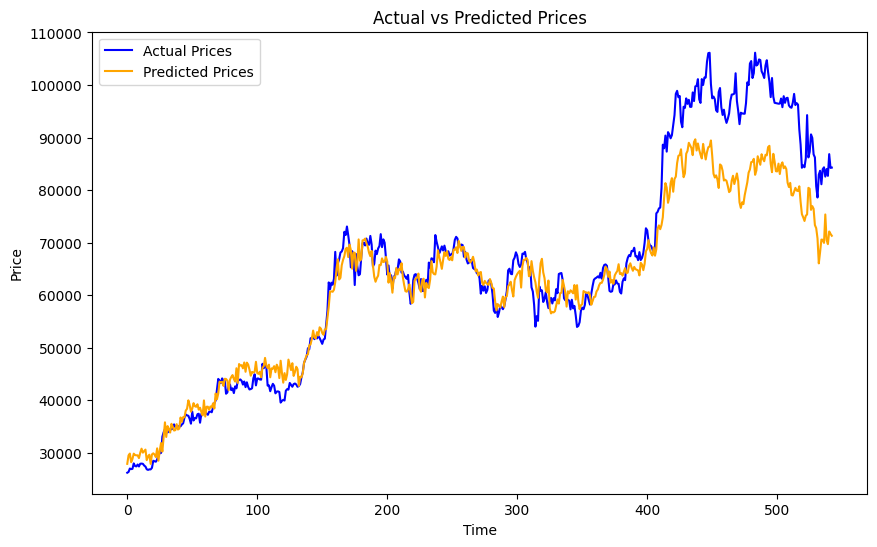

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load and preprocess the data
def load_and_prepare_data(file_path, sequence_length=30):
    """
    Loads the dataset and prepares it for RNN by creating sequences.

    Args:
        file_path (str): Path to the processed CSV file.
        sequence_length (int): Number of time steps in each sequence.

    Returns:
        X_train, X_val, y_train, y_val, scaler: Prepared sequences and corresponding targets.
    """
    # Load the dataset
    df = pd.read_csv(file_path)

    # Scale the features using MinMaxScaler
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])  # Sequence of features
        y.append(scaled_data[i, 0])  # Target is the 'close' price (first column)

    X, y = np.array(X), np.array(y)

    # Split into training and validation sets (80% train, 20% validation)
    split_index = int(0.8 * len(X))
    X_train, X_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]

    return X_train, X_val, y_train, y_val, scaler

# Build the RNN model
def build_rnn_model(input_shape):
    """
    Builds an RNN model.

    Args:
        input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
        model: Compiled RNN model.
    """
    model = Sequential()
    model.add(SimpleRNN(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(SimpleRNN(units=50, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the RNN model
def train_rnn_model(X_train, y_train, X_val, y_val, input_shape, epochs=50, batch_size=32):
    """
    Trains the RNN model.

    Args:
        X_train, y_train: Training data and targets.
        X_val, y_val: Validation data and targets.
        input_shape (tuple): Shape of the input data (timesteps, features).
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        model: Trained RNN model.
        history: Training history object.
    """
    model = build_rnn_model(input_shape)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )
    return model, history

# Evaluate the model
def evaluate_model(model, X_val, y_val, scaler):
    """
    Evaluates the trained RNN model on the validation set.

    Args:
        model: Trained RNN model.
        X_val, y_val: Validation data and targets.
        scaler: Scaler used for normalization.

    Returns:
        None
    """
    # Make predictions on the validation set
    y_val_pred = model.predict(X_val)

    # Inverse transform the predictions and actual values to the original scale
    y_val_pred_original = scaler.inverse_transform(
        np.concatenate((y_val_pred, np.zeros((y_val_pred.shape[0], X_val.shape[2] - 1))), axis=1)
    )[:, 0]
    y_val_original = scaler.inverse_transform(
        np.concatenate((y_val.reshape(-1, 1), np.zeros((y_val.shape[0], X_val.shape[2] - 1))), axis=1)
    )[:, 0]

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    rmse = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

    # Plot actual vs predicted prices
    plt.figure(figsize=(10, 6))
    plt.plot(y_val_original, label="Actual Prices", color="blue")
    plt.plot(y_val_pred_original, label="Predicted Prices", color="orange")
    plt.title("Actual vs Predicted Prices")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Main execution block
if __name__ == "__main__":
    # File path to the processed dataset
    file_path = "data/processed/btc_lstm.csv"

    # Sequence length for RNN
    sequence_length = 30

    # Load and prepare the data
    try:
        X_train, X_val, y_train, y_val, scaler = load_and_prepare_data(file_path, sequence_length)

        # Train the RNN model
        input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
        model, history = train_rnn_model(X_train, y_train, X_val, y_val, input_shape)

        # Evaluate the model
        evaluate_model(model, X_val, y_val, scaler)

    except Exception as e:
        print(f"An error occurred: {e}")

### Save Model

In [15]:
# Save the trained RNN model
model.save("src/models/rnn_model.h5")